In [2]:
pip install deeplake

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 617.7/617.7 kB 30.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.7/17.7 MB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.9/76.9 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 40.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 40.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.6/82.6 kB 5.2 MB/s eta 0:

In [3]:
pip install opencv-python


In [4]:
!pip install torch torchvision albumentations


In [5]:
pip install tensorflow


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import packages

In [7]:
import deeplake
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as patches
import numpy as np
import cv2
import albumentations as A
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.18 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [8]:
ds = deeplake.load("hub://activeloop/carpk-train")

\

Opening dataset in read-only mode as you don't have write permissions.


/

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/carpk-train



\

hub://activeloop/carpk-train loaded successfully.



# 1 Exploratory Data Analysis

### **1.1 Check Dataset Structure**

In [ ]:
# Check dataset structure
ds.summary()


Dataset(path='hub://activeloop/carpk-train', read_only=True, tensors=['images', 'boxes', 'labels'])

 tensor      htype            shape          dtype  compression
 -------    -------          -------        -------  ------- 
 images      image     (989, 720, 1280, 3)   uint8    jpeg   
  boxes      bbox        (989, 1:87, 4)     float32   None   
 labels   class_label      (989, 1:87)      uint32    None   



Images: There are  989 images

Bounding boxes: Each image has between 1 and 87 objects (cars) annotated in the form of bounding boxes.

Labels: Correspond to the object classes, likely indicating the number of cars, and have the same range as the bounding boxes (between 1 and 87 labels per image).

### 1.2 **Visualize Sample Images**

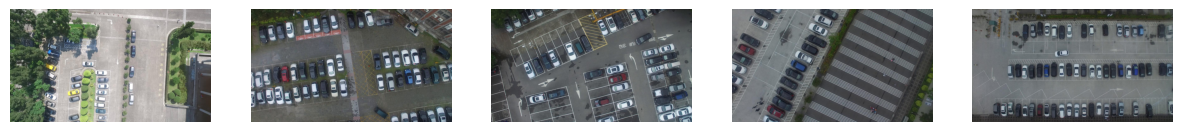

In [ ]:
# Function to display sample images
def show_sample_images(dataset, num_samples=5):
    plt.figure(figsize=(15, 10))

    for i in range(num_samples):
        sample = dataset['images'][i].numpy()  # Accessing the image tensor
        plt.subplot(1, num_samples, i+1)
        plt.imshow(sample)
        plt.axis('off')

    plt.show()

# Display 5 sample images
show_sample_images(ds, num_samples=5)


### 1.3 **Check Image and Label Distribution**

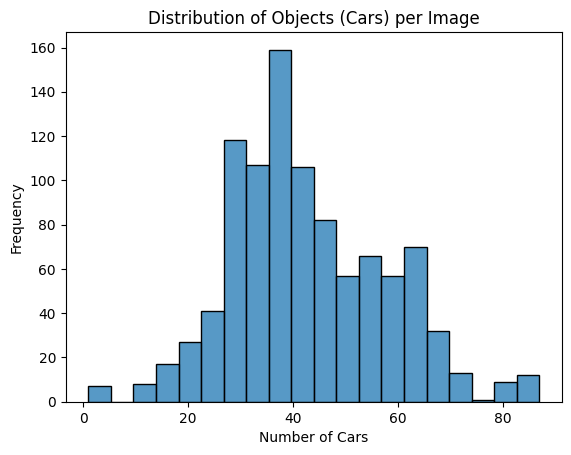

In [ ]:
# Get the number of bounding boxes (cars) in each image
object_counts = [len(sample['boxes'].numpy()) for sample in ds]

# Plot the distribution of object counts per image
sns.histplot(object_counts, bins=20)
plt.title('Distribution of Objects (Cars) per Image')
plt.xlabel('Number of Cars')
plt.ylabel('Frequency')
plt.show()



Most images have between 30 to 50 cars, with the peak at around 40 cars per image.

A small number of images contain fewer than 20 cars or more than 70 cars.

The distribution is fairly balanced, though there are some outliers with very few or many cars.

### 1.4 **Visualize Bounding Boxes on Images (Object Density)**

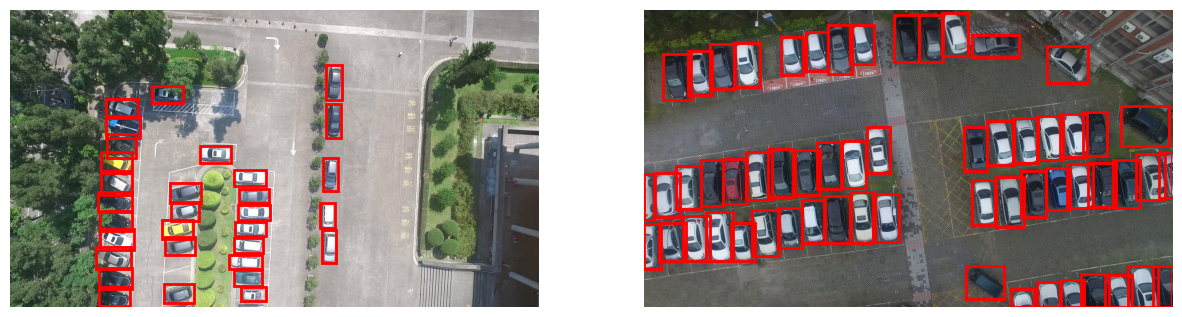

In [ ]:
# Function to display images with bounding boxes using [x_min, y_min, width, height]
def show_original_images_with_boxes_corrected(dataset, num_samples=3):
    plt.figure(figsize=(15, 10))

    for i in range(num_samples):
        # Access the original image
        sample_image = dataset['images'][i].numpy()
        img_height, img_width, _ = sample_image.shape

        # Access the bounding boxes
        boxes = dataset['boxes'][i].numpy()

        # Plot the image
        ax = plt.subplot(1, num_samples, i+1)
        ax.imshow(sample_image)

        # Add bounding boxes
        for box in boxes:
            x_min, y_min, width, height = box  # New format with width and height
            rect = patches.Rectangle(
                (x_min, y_min),  # Start point (top-left corner)
                width,           # Box width
                height,          # Box height
                linewidth=2, edgecolor='r', facecolor='none'
            )
            ax.add_patch(rect)

        plt.axis('off')

    plt.show()

# Display original images with corrected bounding boxes
show_original_images_with_boxes_corrected(ds, num_samples=2)


### **1.5 Check for Missing or Corrupt Data**

In [ ]:
# Check for missing or corrupt data
missing_data_count = 0

for i, sample in enumerate(ds):
    if sample['images'] is None or sample['boxes'] is None or sample['labels'] is None:
        print(f"Missing data in sample {i}")
        missing_data_count += 1

if missing_data_count == 0:
    print("No missing or corrupt data found!")
else:
    print(f"Total samples with missing data: {missing_data_count}")


No missing or corrupt data found!


# 2 Exploratory Data Analysis

### **2.1 Resize Images and Scale Bounding Boxes**

/usr/local/lib/python3.10/dist-packages/deeplake/core/tensor.py:719: UserWarning: Indexing by integer in a for loop, like `for i in range(len(ds)): ... ds.tensor[i]` can be quite slow. Use `for i, sample in enumerate(ds)` instead.
  warnings.warn(


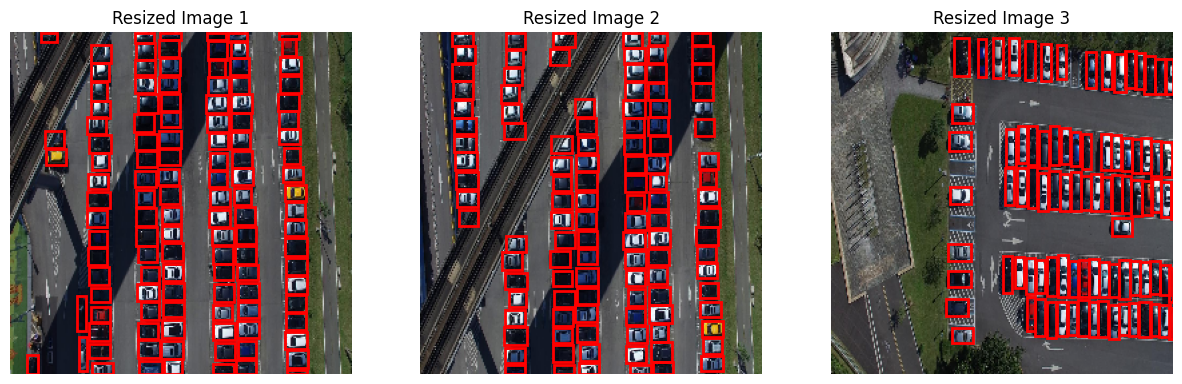

In [13]:
# Function to resize images and scale bounding boxes for the entire dataset
def resize_images_and_boxes(dataset, new_size=(256, 256)):
    resized_images = []
    resized_boxes = []

    original_size = (720, 1280)

    # Loop through all images in the dataset
    for i in range(len(dataset['images'])):
        # Resize image
        sample_image = dataset['images'][i].numpy()
        resized_image = cv2.resize(sample_image, new_size)
        resized_images.append(resized_image)

        # Scale bounding boxes according to the new image size
        sample_boxes = dataset['boxes'][i].numpy()
        x_scale = new_size[1] / original_size[1]  # Width scaling factor
        y_scale = new_size[0] / original_size[0]  # Height scaling factor

        resized_box = []
        for box in sample_boxes:
            x_min, y_min, width, height = box
            resized_box.append([x_min * x_scale, y_min * y_scale, width * x_scale, height * y_scale])
        resized_boxes.append(resized_box)

    return resized_images, resized_boxes

# Resize all images and adjust bounding boxes
resized_images, resized_boxes = resize_images_and_boxes(ds, new_size=(256, 256))

# Function to visualize resized images with bounding boxes
def show_resized_images_with_boxes(resized_images, resized_boxes, num_samples=5):
    plt.figure(figsize=(15, 10))

    for i, img in enumerate(resized_images[:num_samples]):
        ax = plt.subplot(1, num_samples, i + 1)
        ax.imshow(img)

        # Draw bounding boxes
        for box in resized_boxes[i]:
            x_min, y_min, width, height = box
            rect = patches.Rectangle(
                (x_min, y_min),  # Start point (top-left corner)
                width,           # Box width
                height,          # Box height
                linewidth=2, edgecolor='r', facecolor='none'
            )
            ax.add_patch(rect)

        plt.title(f"Resized Image {i+1}")
        plt.axis('off')

    plt.show()

# Display a few resized images with bounding boxes
show_resized_images_with_boxes(resized_images, resized_boxes, num_samples=3)


### **2.2 Normalize Pixel Values**

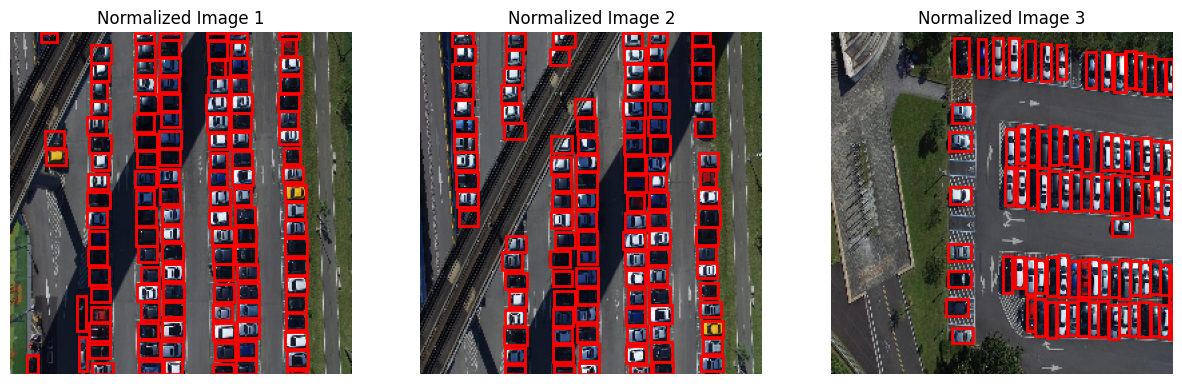

In [14]:
# Modify the normalize_images function to handle 3 channels
def normalize_images(resized_images):
    normalized_images = []
    for image in resized_images:
        # Ensure the image has 3 channels by stacking if it's a grayscale image
        if len(image.shape) == 2:  # Grayscale image case
            image = np.stack([image] * 3, axis=-1)  # Stack to create 3 channels

        # Transpose the image to match the format (C, H, W) expected by PyTorch (3 channels first)
        normalized_image = np.transpose(image / 255.0, (2, 0, 1))  # Normalize and reshape to (3, H, W)
        normalized_images.append(normalized_image)
    return normalized_images


# Normalize the resized images
normalized_images = normalize_images(resized_images)

# Function to display normalized images with bounding boxes
def show_normalized_images_with_boxes(normalized_images, resized_boxes, num_samples=5):
    plt.figure(figsize=(15, 10))

    for i, normalized_image in enumerate(normalized_images[:num_samples]):
        # Transpose back to (H, W, C) for visualization
        image_to_display = np.transpose(normalized_image, (1, 2, 0))

        ax = plt.subplot(1, num_samples, i + 1)
        ax.imshow(image_to_display)

        # Draw bounding boxes
        for box in resized_boxes[i]:
            x_min, y_min, width, height = box
            rect = patches.Rectangle(
                (x_min, y_min),  # Start point (top-left corner)
                width,           # Box width
                height,          # Box height
                linewidth=2, edgecolor='r', facecolor='none'
            )
            ax.add_patch(rect)

        plt.title(f"Normalized Image {i+1}")
        plt.axis('off')

    plt.show()

# Display a few normalized images with bounding boxes
show_normalized_images_with_boxes(normalized_images, resized_boxes, num_samples=3)




In [15]:
# Check the shape of an image after normalization
print(f"Shape of a normalized image: {normalized_images[0].shape}")


Shape of a normalized image: (3, 256, 256)


In [16]:
# Check the total number of images
print(f"Total number of images: {len(normalized_images)}")
print(f"Total number of bounding boxes: {len(resized_boxes)}")


Total number of images: 459
Total number of bounding boxes: 459


# 3 Model training

In [17]:
import numpy as np
from sklearn.model_selection import train_test_split

# Create labels: number of cars per image
labels = np.array([len(boxes) for boxes in resized_boxes])

# Convert images to numpy array
images = np.array(normalized_images)

print(f"Total images: {images.shape[0]}")
print(f"Total labels: {labels.shape[0]}")

# Split into training and validation sets (e.g., 80% training, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(
    images, labels, test_size=0.2, random_state=42
)

print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")


Total images: 459
Total labels: 459
Training set size: 367
Validation set size: 92


#### CNN-Based

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

# Define custom Dataset class
class CarCountingDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images.astype(np.float32)  # Convert to float32 for compatibility with PyTorch
        self.labels = labels.astype(np.float32)  # Ensure labels are in float32
        self.transform = transform  # Apply data augmentation (if any)

    def __len__(self):
        return len(self.images)  # Number of images

    def __getitem__(self, idx):
        image = self.images[idx]  # Get image by index
        label = self.labels[idx]  # Get corresponding label

        # Convert to PIL Image for transforms
        image = image.transpose(1, 2, 0)  # Convert from (C, H, W) to (H, W, C) for PIL compatibility
        image = (image * 255).astype(np.uint8)  # Convert back to 8-bit
        image = Image.fromarray(image)

        if self.transform:
            image = self.transform(image)  # Apply transformations

        return image, torch.tensor(label)  # Return the image and label as tensors

# Define data augmentation and normalization for training
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.4, contrast=0.4),
    transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
    transforms.ToTensor(),
])


# Define just normalization for validation (no augmentation)
val_transform = transforms.Compose([
    transforms.ToTensor(),  # Convert to tensor and normalize
])

# Create datasets
train_dataset = CarCountingDataset(X_train, y_train, transform=train_transform)
val_dataset = CarCountingDataset(X_val, y_val, transform=val_transform)

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


In [ ]:
class CarCounterCNN(nn.Module):
    def __init__(self):
        super(CarCounterCNN, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)

        # Batch Normalization and Dropout
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
        self.dropout = nn.Dropout(0.5)

        # Pooling layer
        self.pool = nn.MaxPool2d(2, 2)

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 64 * 64, 512)  # Adjusted input size for fc1
        self.fc2 = nn.Linear(512, 1)  # Output 1 value (regression)

    def forward(self, x):
        # Convolutional layers with ReLU and pooling
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = F.relu(self.bn3(self.conv3(x)))

        # Flatten the output from the conv layers
        x = x.view(x.size(0), -1)  # Flatten the tensor to (batch_size, 128 * 64 * 64)

        # Fully connected layers
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)  # Regression output

        return x.squeeze()  # Return a single value per image in the batch


In [ ]:
import torch.optim as optim

# Initialize the model, loss function, and optimizer
model = CarCounterCNN().to(device)
criterion = nn.MSELoss()  # Mean Squared Error for regression
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)


# Learning rate scheduler to reduce learning rate when validation loss plateaus
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5, verbose=True)


# Training loop
num_epochs = 30
best_val_loss = float('inf')

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    # Training phase
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()  # Clear gradients
        outputs = model(images)  # Forward pass
        loss = criterion(outputs, labels)  # Calculate loss
        loss.backward()  # Backward pass (gradient calculation)
        optimizer.step()  # Update model weights

        running_loss += loss.item() * images.size(0)  # Accumulate total loss

    # Calculate average training loss
    epoch_loss = running_loss / len(train_dataset)
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.4f}")

    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)

    # Calculate average validation loss
    val_loss /= len(val_dataset)
    print(f"Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss:.4f}")

    # Learning rate adjustment
    scheduler.step(val_loss)

    # Save the best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_car_counting_model.pth')


Epoch 1/30, Training Loss: 11597.8913
Epoch 1/30, Validation Loss: 601.3747
Epoch 2/30, Training Loss: 743.2631
Epoch 2/30, Validation Loss: 425.5436
Epoch 3/30, Training Loss: 622.8865
Epoch 3/30, Validation Loss: 164.2910
Epoch 4/30, Training Loss: 683.1913
Epoch 4/30, Validation Loss: 213.4776
Epoch 5/30, Training Loss: 654.4876
Epoch 5/30, Validation Loss: 297.6701
Epoch 6/30, Training Loss: 685.1890
Epoch 6/30, Validation Loss: 122.6142
Epoch 7/30, Training Loss: 582.6008
Epoch 7/30, Validation Loss: 195.5600
Epoch 8/30, Training Loss: 619.5064
Epoch 8/30, Validation Loss: 222.5823
Epoch 9/30, Training Loss: 614.7057
Epoch 9/30, Validation Loss: 216.8847
Epoch 10/30, Training Loss: 623.7024
Epoch 10/30, Validation Loss: 123.9223
Epoch 11/30, Training Loss: 641.5702
Epoch 11/30, Validation Loss: 140.2561
Epoch 12/30, Training Loss: 585.8589
Epoch 12/30, Validation Loss: 194.6371
Epoch 13/30, Training Loss: 614.5181
Epoch 13/30, Validation Loss: 209.1355
Epoch 14/30, Training Loss: 

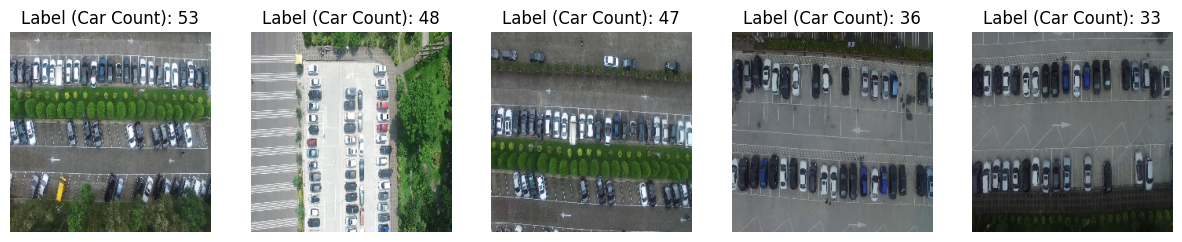

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Function to display a few images and their corresponding labels
def display_sample_images(images, labels, num_samples=5):
    plt.figure(figsize=(15, 10))

    for i in range(num_samples):
        img = images[i].transpose(1, 2, 0)  # Convert from (C, H, W) to (H, W, C)
        img = (img * 255).astype(np.uint8)  # Scale back to [0, 255] range

        plt.subplot(1, num_samples, i+1)
        plt.imshow(img)
        plt.title(f"Label (Car Count): {labels[i]}")
        plt.axis('off')

    plt.show()

# Display 5 sample images and their labels from the training set
display_sample_images(X_train, y_train, num_samples=5)


In [ ]:
# Load the best model
model.load_state_dict(torch.load('best_car_counting_model.pth'))

# Set the model to evaluation mode
model.eval()

# Evaluation on the validation set or test set
test_loss = 0.0
predictions = []
actuals = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Accumulate loss
        test_loss += loss.item() * images.size(0)

        # Store predictions and actuals for analysis
        predictions.extend(outputs.cpu().numpy())
        actuals.extend(labels.cpu().numpy())

# Calculate average test loss
test_loss /= len(val_dataset)  # Or len(test_dataset)
print(f"Test Loss: {test_loss:.4f}")


<ipython-input-49-afd0c2e75505>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_car_counting_model.pth'))


Test Loss: 122.6142


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(actuals, predictions)
rmse = mean_squared_error(actuals, predictions, squared=False)

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")


Mean Absolute Error (MAE): 8.06
Root Mean Squared Error (RMSE): 11.07


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


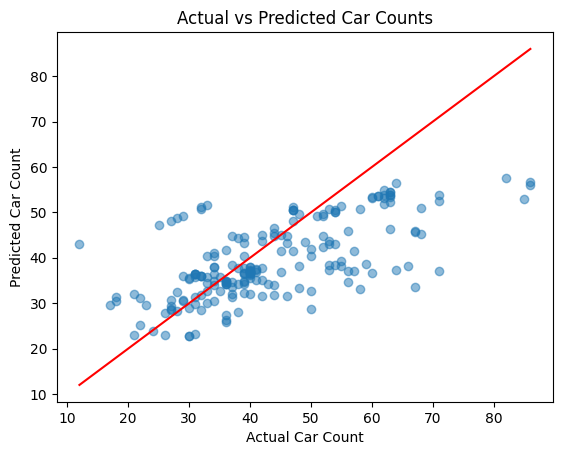

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(actuals, predictions, alpha=0.5)
plt.plot([min(actuals), max(actuals)], [min(actuals), max(actuals)], 'r')
plt.xlabel('Actual Car Count')
plt.ylabel('Predicted Car Count')
plt.title('Actual vs Predicted Car Counts')
plt.show()


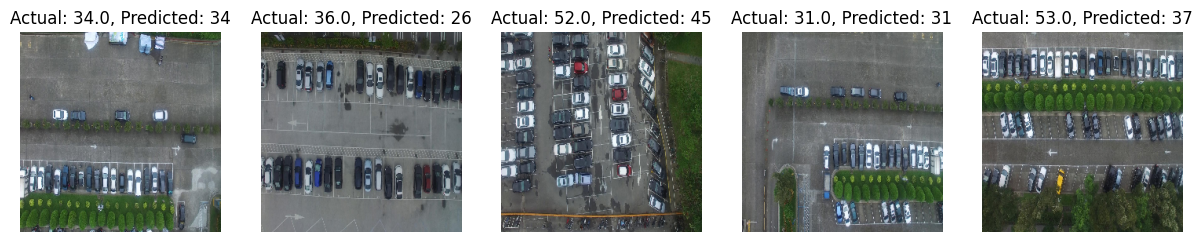

In [ ]:
import matplotlib.pyplot as plt

# Function to display sample images with predicted and actual car counts
def display_predictions(images, actuals, predictions, num_samples=5):
    plt.figure(figsize=(15, 15))

    for i in range(num_samples):
        img = images[i].cpu().numpy().transpose(1, 2, 0)  # Convert image from (C, H, W) to (H, W, C)
        img = (img * 255).astype(np.uint8)  # Rescale the image to [0, 255] range

        plt.subplot(1, num_samples, i + 1)
        plt.imshow(img)
        plt.title(f"Actual: {actuals[i]}, Predicted: {round(predictions[i])}")  # Round predictions to nearest integer
        plt.axis('off')

    plt.show()

# Use the validation set to generate predictions
with torch.no_grad():
    model.eval()
    predictions = []
    actuals = []
    sample_images = []

    for images, labels in val_loader:  # Use val_loader for the validation dataset
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        predictions.extend(outputs.cpu().numpy())
        actuals.extend(labels.cpu().numpy())
        sample_images.extend(images.cpu())  # Store the images for display

    # Display 5 sample images with their predicted and actual car counts
    display_predictions(sample_images, actuals, predictions, num_samples=5)


### Improved

In [51]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from torchvision import transforms
from torchvision.transforms import ToTensor
from torch.optim.lr_scheduler import ReduceLROnPlateau
import numpy as np
from PIL import Image

# Create labels: number of cars per image
labels = np.array([len(boxes) for boxes in resized_boxes])

# Convert images to numpy array
images = np.array(normalized_images)

print(f"Total images: {images.shape[0]}")
print(f"Total labels: {labels.shape[0]}")

# Split into training and validation sets (80% training, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(
    images, labels, test_size=0.2, random_state=42
)

print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")

# Custom Dataset class
class CarCountingDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        # Ensure the image has 3 channels (RGB)
        if image.ndim == 2:  # If grayscale
            image = np.stack([image] * 3, axis=-1)
        elif image.shape[0] == 3:  # If (C, H, W), convert to (H, W, C)
            image = image.transpose(1, 2, 0)

        # Convert to uint8
        if image.dtype != np.uint8:
            image = (image * 255).astype(np.uint8)

        # Handle shape mismatch
        if image.shape[2] != 3:
            raise ValueError(f"Unexpected image shape: {image.shape}. Expected (H, W, 3).")

        # Transform to PIL Image
        image = Image.fromarray(image)

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.float32)

# Define transformations
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.4, contrast=0.4),
    transforms.RandomResizedCrop(size=224, scale=(0.8, 1.0)),  # ResNet expects 224x224 input
    ToTensor(),
])

val_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    ToTensor(),
])

# Create datasets
train_dataset = CarCountingDataset(X_train, y_train, transform=train_transform)
val_dataset = CarCountingDataset(X_val, y_val, transform=val_transform)

# Create dataloaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Load a pre-trained ResNet model and modify the final layer
model = models.resnet18(pretrained=True)  # You can use resnet50 or resnet101 for more power
model.fc = nn.Linear(model.fc.in_features, 1)  # Change output layer for regression

# Move model to device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Set up loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

# Training loop with early stopping
num_epochs = 50
early_stopping_patience = 5
best_val_loss = float('inf')
epochs_no_improve = 0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_dataset)
    print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {epoch_loss:.4f}")

    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs.squeeze(), labels)
            val_loss += loss.item() * images.size(0)

    val_loss /= len(val_dataset)
    print(f"Epoch {epoch + 1}/{num_epochs}, Validation Loss: {val_loss:.4f}")

    scheduler.step(val_loss)

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_resnet_car_counting_model.pth')
        epochs_no_improve = 0
        print(f"New best model saved with validation loss: {val_loss:.4f}")
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= early_stopping_patience:
            print("Early stopping triggered. Training stopped.")
            break


Total images: 989
Total labels: 989
Training set size: 791
Validation set size: 198


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 150MB/s]


Epoch 1/50, Training Loss: 1881.9319
Epoch 1/50, Validation Loss: 2064.6405
New best model saved with validation loss: 2064.6405
Epoch 2/50, Training Loss: 1613.2928
Epoch 2/50, Validation Loss: 1493.3468
New best model saved with validation loss: 1493.3468
Epoch 3/50, Training Loss: 1424.8454
Epoch 3/50, Validation Loss: 1315.0640
New best model saved with validation loss: 1315.0640
Epoch 4/50, Training Loss: 1304.7853
Epoch 4/50, Validation Loss: 1149.5608
New best model saved with validation loss: 1149.5608
Epoch 5/50, Training Loss: 1211.2096
Epoch 5/50, Validation Loss: 1060.8271
New best model saved with validation loss: 1060.8271
Epoch 6/50, Training Loss: 1114.7819
Epoch 6/50, Validation Loss: 982.6884
New best model saved with validation loss: 982.6884
Epoch 7/50, Training Loss: 1032.6659
Epoch 7/50, Validation Loss: 955.6550
New best model saved with validation loss: 955.6550
Epoch 8/50, Training Loss: 959.9088
Epoch 8/50, Validation Loss: 855.8618
New best model saved with v

In [59]:
import torch
import torch.nn as nn
from torchvision import models

# Load the model architecture
model = models.resnet18()
model.fc = nn.Linear(model.fc.in_features, 1)  # Update the output layer for regression

# Load the model with map_location set to 'cpu' to handle the absence of GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.load_state_dict(torch.load('best_resnet_car_counting_model.pth', map_location='cpu'))
model.to(device)
model.eval()  # Set the model to evaluation mode

# Function to validate the model
def validate_model(model, val_loader, criterion, device):
    model.eval()
    val_loss = 0.0
    predictions = []
    actuals = []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs.squeeze(), labels)

            # Accumulate the loss
            val_loss += loss.item() * images.size(0)

            # Collect predictions and actual values for further evaluation
            predictions.extend(outputs.squeeze().cpu().numpy())
            actuals.extend(labels.cpu().numpy())

    # Calculate average validation loss
    val_loss /= len(val_loader.dataset)
    print(f"Validation Loss: {val_loss:.4f}")

    return val_loss, predictions, actuals

# Define the criterion for evaluation
criterion = nn.MSELoss()

# Perform validation
val_loss, predictions, actuals = validate_model(model, val_loader, criterion, device)

# Optional: Display results
import matplotlib.pyplot as plt

plt.scatter(actuals, predictions, alpha=0.6)
plt.xlabel("Actual Number of Cars")
plt.ylabel("Predicted Number of Cars")
plt.title("Actual vs. Predicted Car Counts")
plt.show()


Validation Loss: 6.1118


In [62]:
import matplotlib.pyplot as plt
import torch

# Load the best model weights using map_location to ensure it loads correctly on the current device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.load_state_dict(torch.load('best_resnet_car_counting_model.pth', map_location=torch.device('cpu')))
model.to(device)
model.eval()  # Set the model to evaluation mode

# Function to display predictions
def show_predictions(num_images=5):
    model.eval()
    fig, axs = plt.subplots(1, num_images, figsize=(15, 5))
    fig.suptitle('Predicted vs Actual Car Counts')

    for i in range(num_images):
        image, label = val_dataset[i]
        input_image = image.unsqueeze(0).to(device)  # Add batch dimension and move to device

        # Get the model's prediction
        with torch.no_grad():
            predicted_count = model(input_image).item()

        # Display the image, predicted count, and actual count
        image_np = image.permute(1, 2, 0).numpy()  # Convert from tensor (C, H, W) to (H, W, C)
        axs[i].imshow(image_np)
        axs[i].set_title(f'Predicted: {predicted_count:.1f}\nActual: {label.item()}')
        axs[i].axis('off')

    plt.show()

# Display predictions for a few images
show_predictions(num_images=5)


In [66]:
%matplotlib inline


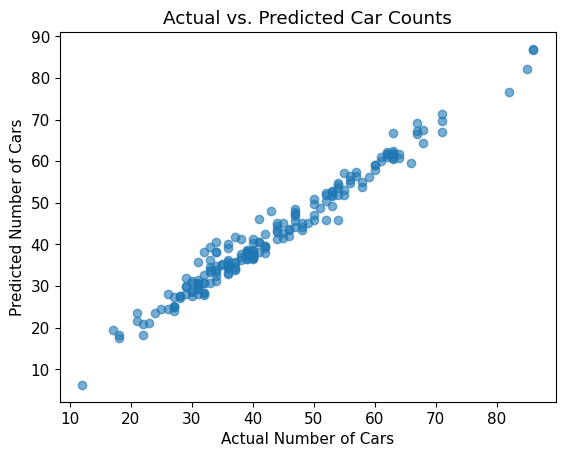

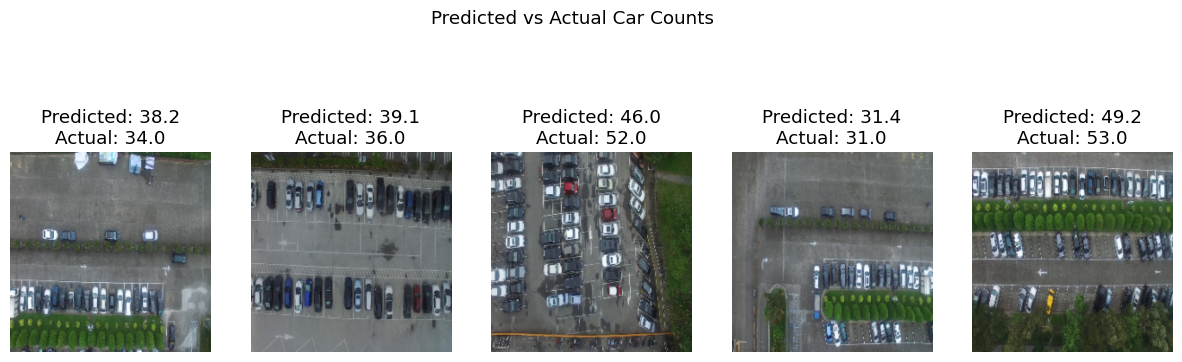

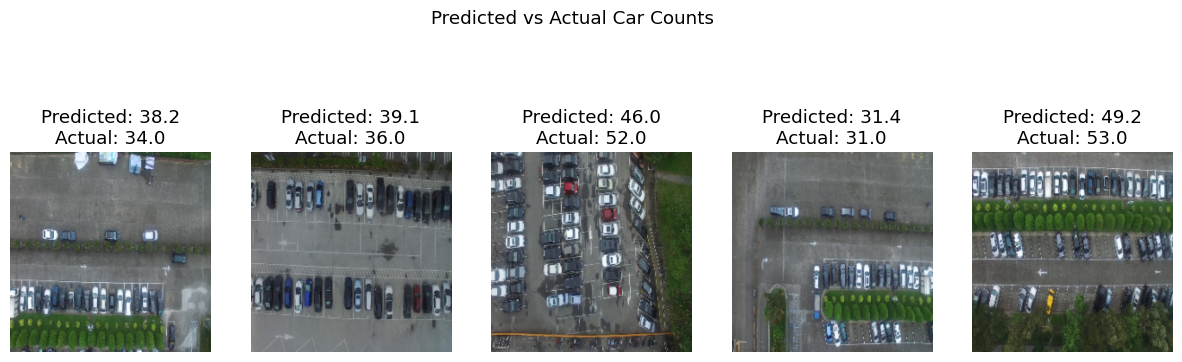

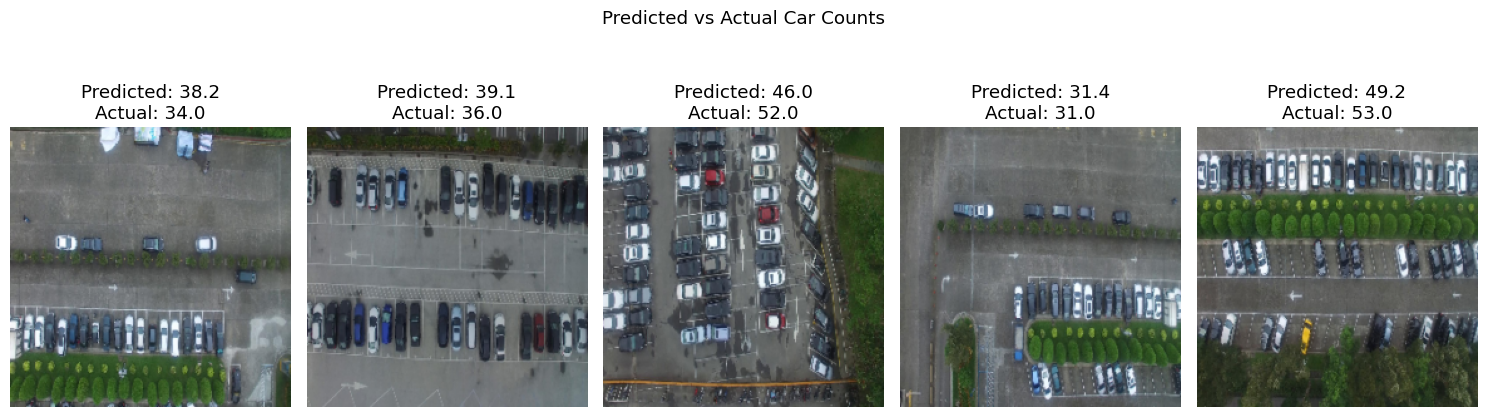

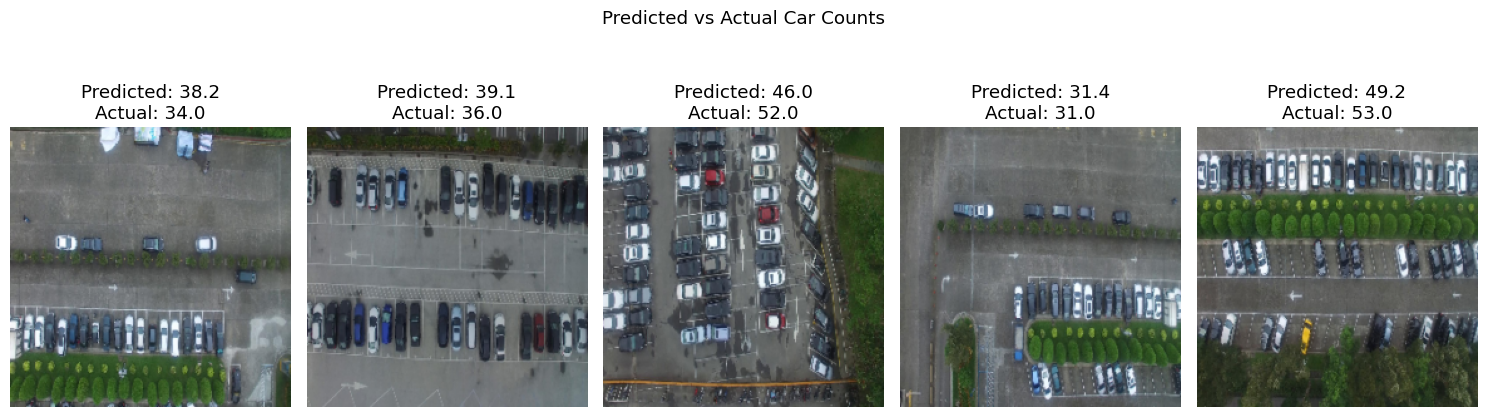

In [69]:
import torch
import matplotlib.pyplot as plt

# Specify the device explicitly
device = torch.device('cpu')  # Use CPU explicitly if CUDA is not available

# Load the model weights using map_location to force loading on the CPU
model.load_state_dict(torch.load('best_resnet_car_counting_model.pth', map_location='cpu'))
model.to(device)  # Move the model to the specified device (CPU in this case)
model.eval()  # Set the model to evaluation mode

# Function to display predictions
def show_predictions(num_images=5):
    model.eval()
    fig, axs = plt.subplots(1, num_images, figsize=(15, 5))
    fig.suptitle('Predicted vs Actual Car Counts')

    for i in range(num_images):
        image, label = val_dataset[i]
        input_image = image.unsqueeze(0).to(device)  # Add batch dimension and move to device

        # Get the model's prediction
        with torch.no_grad():
            predicted_count = model(input_image).item()

        # Convert tensor image to numpy and denormalize if required
        image_np = image.permute(1, 2, 0).numpy()  # Convert from tensor (C, H, W) to (H, W, C)
        image_np = image_np.clip(0, 1)  # Ensure values are between 0 and 1 for proper display

        # Display the image, predicted count, and actual count
        axs[i].imshow(image_np)
        axs[i].set_title(f'Predicted: {predicted_count:.1f}\nActual: {label.item()}')
        axs[i].axis('off')

    plt.tight_layout()
    plt.show()

# Display predictions for a few images
show_predictions(num_images=5)
